In [1]:
from __future__ import print_function
from imp import reload

## UAT for NbAgg backend.

The first line simply reloads matplotlib, uses the nbagg backend and then reloads the backend, just to ensure we have the latest modification to the backend code. Note: The underlying JavaScript will not be updated by this process, so a refresh of the browser after clearing the output and saving is necessary to clear everything fully.

In [2]:
import matplotlib
reload(matplotlib)

%matplotlib notebook


<module 'matplotlib.backends.backend_nbagg' from '/Users/ssilvester/workspace/matplotlib/lib/matplotlib/backends/backend_nbagg.py'>

### UAT 1 - Simple figure creation using pyplot

Should produce a figure window which is interactive with the pan and zoom buttons. (Do not press the close button, but any others may be used).

<IPython.core.display.Javascript object>


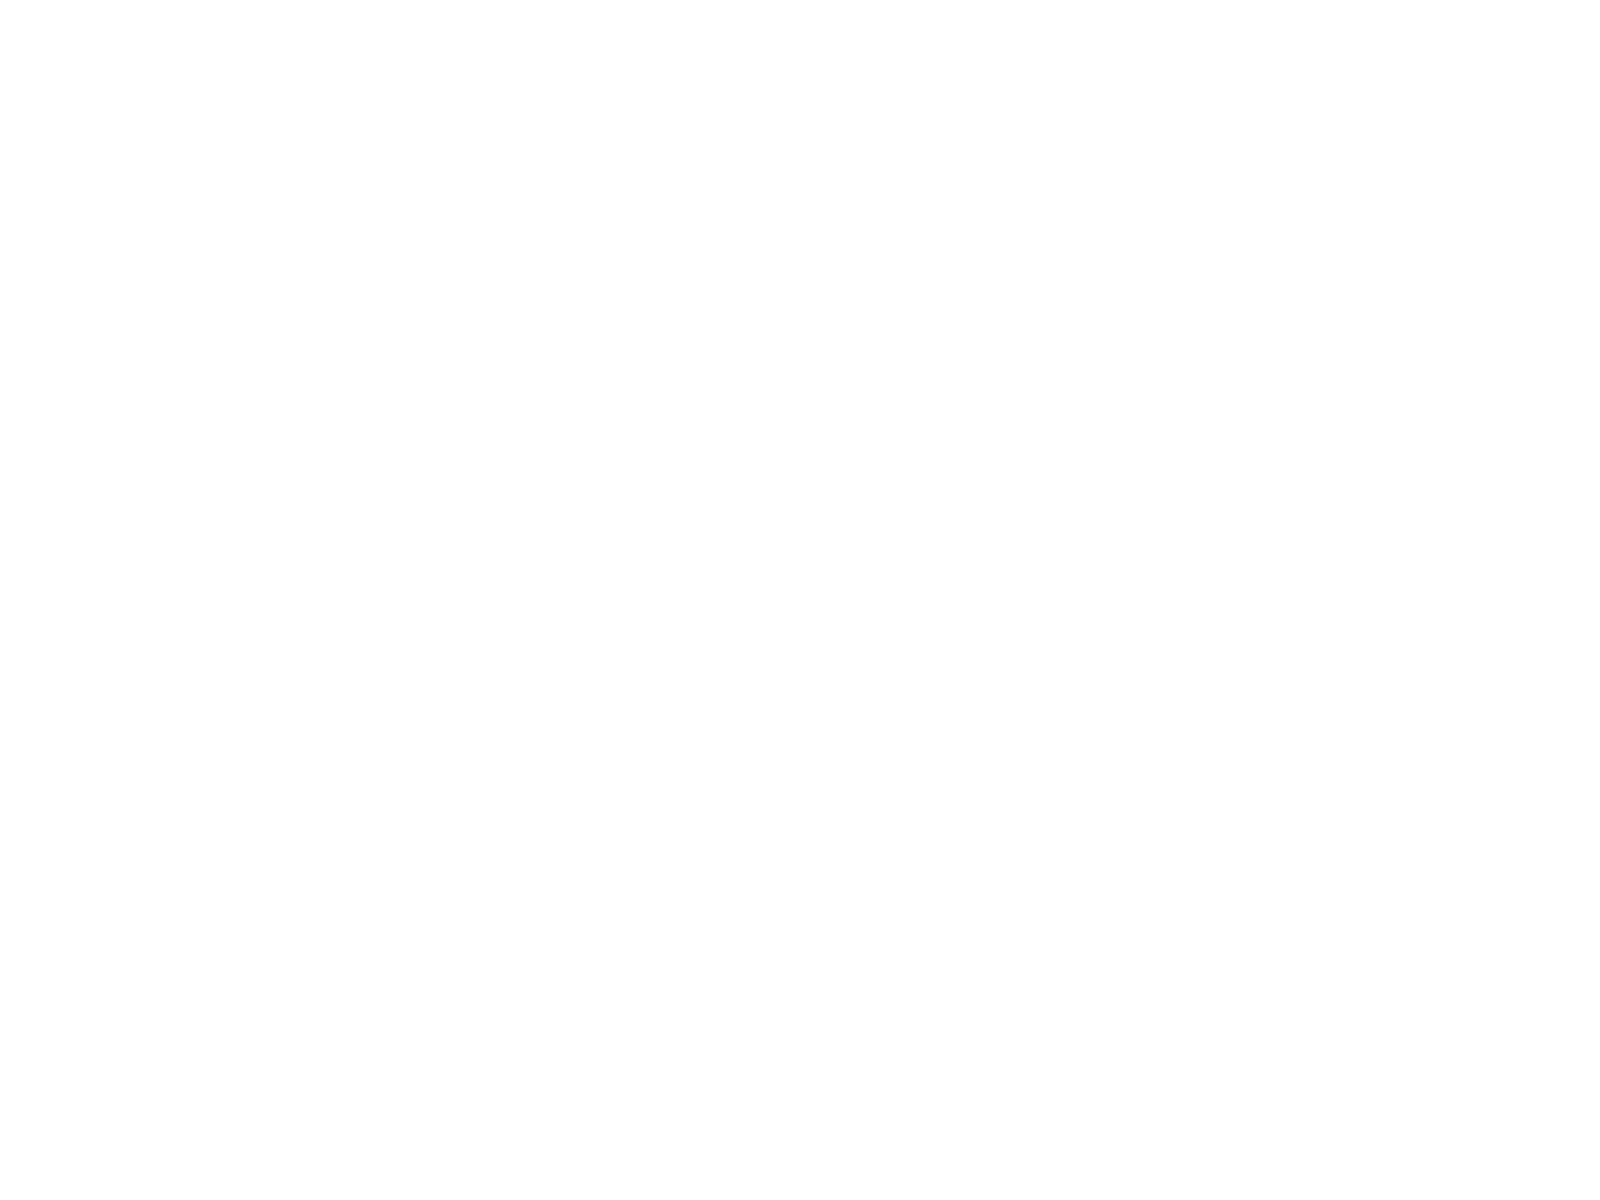

In [3]:


import matplotlib.pyplot as plt
plt.interactive(False)

fig1 = plt.figure()
plt.plot(range(10))

plt.show()

### UAT 2 - Creation of another figure, without the need to do plt.figure.

As above, a new figure should be created.

In [4]:
plt.plot([3, 2, 1])
plt.show()

<IPython.core.display.Javascript object>

### UAT 3 - Connection info

The printout should show that there are two figures which have active CommSockets, and no figures pending show.

In [5]:
print(matplotlib.backends.backend_nbagg.connection_info())

Figure 1 - Figure 1
Figure 2 - Figure 2
Figures pending show: 0


### UAT 4 - Closing figures

Closing a specific figure instance should turn the figure into a plain image - the UI should have been removed. In this case, scroll back to the first figure and assert this is the case.

In [6]:
plt.close(fig1)

### UAT 5 - No show without plt.show in non-interactive mode

Simply doing a plt.plot should not show a new figure, nor indeed update an existing one (easily verified in UAT 6).
The output should simply be a list of Line2D instances.

In [7]:
plt.plot(range(10))

### UAT 6 - Connection information

We just created a new figure, but didn't show it. Connection info should no longer have "Figure 1" (as we closed it in UAT 4) and should have figure 2 and 3, with Figure 3 without any connections. There should be 1 figure pending.

In [8]:
print(matplotlib.backends.backend_nbagg.connection_info())

Figure 2 - Figure 2
Figure 3 - Figure 3
Figures pending show: 1


### UAT 7 - Show of previously created figure

We should be able to show a figure we've previously created. The following should produce two figure windows.

In [9]:
plt.show()
plt.figure()
plt.plot(range(5))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### UAT 8 - Interactive mode

In interactive mode, creating a line should result in a figure being shown.

In [10]:
plt.interactive(True)
plt.figure()
plt.plot([3, 2, 1])

<IPython.core.display.Javascript object>

Subsequent lines should be added to the existing figure, rather than creating a new one.

In [11]:
plt.plot(range(3))

Calling connection_info in interactive mode should not show any pending figures.

In [12]:
print(matplotlib.backends.backend_nbagg.connection_info())

Figure 2 - Figure 2
Figure 3 - Figure 3
Figure 4 - Figure 4
Figure 5 - Figure 5


Disable interactive mode again.

In [13]:
plt.interactive(False)

### UAT 9 - Multiple shows

Unlike most of the other matplotlib backends, we may want to see a figure multiple times (with or without synchronisation between the views, though the former is not yet implemented). Assert that plt.gcf().canvas.manager.reshow() results in another figure window which is synchronised upon pan & zoom.

In [14]:
plt.gcf().canvas.manager.reshow()

<IPython.core.display.Javascript object>

### UAT 10 - Saving notebook

Saving the notebook (with CTRL+S or File->Save) should result in the saved notebook having static versions of the figues embedded within. The image should be the last update from user interaction and interactive plotting. (check by converting with ``ipython nbconvert <notebook>``)

### UAT 11 - Creation of a new figure on second show

Create a figure, show it, then create a new axes and show it. The result should be a new figure.

**BUG: Sometimes this doesn't work - not sure why (@pelson).**

In [15]:
fig = plt.figure()
plt.axes()
plt.show()

plt.plot([1, 2, 3])
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### UAT 12 - OO interface

Should produce a new figure and plot it.

In [16]:
from matplotlib.backends.backend_nbagg import new_figure_manager,show

manager = new_figure_manager(1000)
fig = manager.canvas.figure
ax = fig.add_subplot(1,1,1)
ax.plot([1,2,3])
fig.show()

<IPython.core.display.Javascript object>

## UAT 13 - Animation

The following should generate an animated line:

In [17]:
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)        # x-array
line, = ax.plot(x, np.sin(x))

def animate(i):
    line.set_ydata(np.sin(x+i/10.0))  # update the data
    return line,

#Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=32., blit=True)
plt.show()

<IPython.core.display.Javascript object>

### UAT 14 - Keyboard shortcuts in IPython after close of figure

After closing the previous figure (with the close button above the figure) the IPython keyboard shortcuts should still function.

### UAT 15 - Figure face colours

The nbagg honours all colours appart from that of the figure.patch. The two plots below should produce a figure with a transparent background and a red background respectively (check the transparency by closing the figure, and dragging the resulting image over other content). There should be no yellow figure.

In [18]:
import matplotlib
matplotlib.rcParams.update({'figure.facecolor': 'red',
                            'savefig.facecolor': 'yellow'})
plt.figure()
plt.plot([3, 2, 1])

with matplotlib.rc_context({'nbagg.transparent': False}):
    plt.figure()

plt.plot([3, 2, 1])
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### UAT 16 - Events

Pressing any keyboard key or mouse button (or scrolling) should cycle the line line while the figure has focus.  The figure should have focus by default when it is created and re-gain it by clicking on the canvas.  Clicking anywhere outside of the figure should release focus, but moving the mouse out of the figure should not release focus.

In [19]:
import itertools
fig, ax = plt.subplots()
x = np.linspace(0,10,10000)
y = np.sin(x)
ln, = ax.plot(x,y)
evt = []
colors = iter(itertools.cycle(['r', 'g', 'b', 'k', 'c']))
def on_event(event):
    if event.name.startswith('key'):
        fig.suptitle('%s: %s' % (event.name, event.key))
    elif event.name == 'scroll_event':
        fig.suptitle('%s: %s' % (event.name, event.step))
    else:
        fig.suptitle('%s: %s' % (event.name, event.button))
    evt.append(event)
    ln.set_color(next(colors))
    fig.canvas.draw()
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', on_event)
fig.canvas.mpl_connect('button_release_event', on_event)
fig.canvas.mpl_connect('scroll_event', on_event)
fig.canvas.mpl_connect('key_press_event', on_event)
fig.canvas.mpl_connect('key_release_event', on_event)

plt.show()

AttributeError: 'module' object has no attribute 'is_sorted'

### UAT 17 - Timers

Single-shot timers follow a completely different code path in the nbagg backend than regular timers (such as those used in the animation example above.)  The next set of tests ensures that both "regular" and "single-shot" timers work properly.

The following should show a simple clock that updates twice a second:

In [ ]:
import time

fig, ax = plt.subplots()
text = ax.text(0.5, 0.5, '', ha='center')

def update(text):
    text.set(text=time.ctime())
    text.axes.figure.canvas.draw()
    
timer = fig.canvas.new_timer(500, [(update, [text], {})])
timer.start()
plt.show()

However, the following should only update once and then stop:

In [ ]:
fig, ax = plt.subplots()
text = ax.text(0.5, 0.5, '', ha='center') 
timer = fig.canvas.new_timer(500, [(update, [text], {})])

timer.single_shot = True
timer.start()

plt.show()

And the next two examples should never show any visible text at all:

In [ ]:
fig, ax = plt.subplots()
text = ax.text(0.5, 0.5, '', ha='center')
timer = fig.canvas.new_timer(500, [(update, [text], {})])

timer.start()
timer.stop()

plt.show()

In [ ]:
fig, ax = plt.subplots()
text = ax.text(0.5, 0.5, '', ha='center')
timer = fig.canvas.new_timer(500, [(update, [text], {})])

timer.single_shot = True
timer.start()
timer.stop()

plt.show()

### UAT17 - stoping figure when removed from DOM

When the div that contains from the figure is removed from the DOM the figure should shut down it's comm, and if the python-side figure has no more active comms, it should destroy the figure. Repeatedly running the cell below should always have the same figure number

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(5))
plt.show()

Running the cell below will re-show the figure. After this, re-running the cell above should result in a new figure number.

In [ ]:
fig.canvas.manager.reshow()

### UAT 18 - Blitting
Clicking on the figure should plot a green horizontal line moving up the axes.

In [21]:
import matplotlib.pyplot as plt
prev_artist = None
cur_y = 0.1

def onclick_handle(event):
    """Should draw elevating green line on each mouse click"""
    global ax, bg, prev_artist, cur_y
    ax.figure.canvas.restore_region(bg)
    if prev_artist:
        prev_artist.remove()
    cur_y += 0.1
    prev_artist = ax.plot([0, 1], [cur_y, cur_y], 'g')[0]
    ax.draw_artist(prev_artist)
    ax.figure.canvas.blit(ax.bbox)
    print("Drew line")

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'r')
plt.show()
ax.figure.canvas.draw()
bg = ax.figure.canvas.copy_from_bbox(ax.bbox)
ax.figure.canvas.mpl_connect('button_press_event', onclick_handle)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: 'module' object has no attribute 'PNG_FILTER_NONE'